In [147]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from skopt.space import Real, Categorical, Integer
import xgboost as xgb
from xgboost import XGBClassifier
import os
import gc
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
import lightgbm as lgb
from sklearn.svm import LinearSVC, SVC
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,PolynomialFeatures
import warnings
warnings.simplefilter('ignore')
TrainDataDir = '../data/'
ModelSaveDir = 'models'
ResultSaveDir = 'result2'
ResultSaveDir_open = 'result_open'

In [148]:
def loadData(Dir, DataName, index_col_flag = False):
    DataPath = os.path.join(Dir, DataName)
    if not os.path.exists(DataPath):
        print('%s does not exist!' % DataPath)
        return
    if index_col_flag:
        OriginData = pd.read_csv(DataPath,index_col=0)
    else:
        OriginData = pd.read_csv(DataPath)
    #OriginData = OriginData.sample(frac=1)  # 打乱顺序后返回
    return OriginData

In [149]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGBOOST Features (avg over folds)')
    plt.tight_layout()

In [150]:
# Splitting data
from sklearn.model_selection import train_test_split

N_FOLDS = 5
MAX_EVALS = 5

### 1.加载数据

In [151]:
X = loadData(TrainDataDir,'df_train_oof.csv',True)

In [152]:
X.head()

,SK_ID_CURR,TARGET,lgb0819_pred,lgb0825_pred,lgb1_pred_x,lgb10_pred_x,lgb11_pred_x,lgb2_pred_x,lgb3_pred_x,lgb4_pred_x,...,xgb18_pred,xgb19_pred,xgb2_pred,xgb3_pred,xgb4_pred,xgb5_pred,xgb6_pred,xgb7_pred,xgb8_pred,xgb9_pred
0,100002,1.0,0.276478,0.389494,0.364570,0.348369,0.306277,0.330778,0.509886,0.264999,...,0.218072,0.163460,0.306949,0.438685,0.416051,0.245251,0.243865,0.229545,0.200648,0.183082
1,100003,0.0,0.017370,0.022210,0.017217,0.016348,0.020144,0.019681,0.028110,0.013785,...,0.014948,0.015859,0.019579,0.044400,0.038373,0.020704,0.022618,0.017725,0.015483,0.019762
2,100004,0.0,0.036509,0.036619,0.042637,0.037136,0.034180,0.037103,0.073552,0.035479,...,0.030056,0.031891,0.039760,0.089611,0.083794,0.036716,0.038883,0.030704,0.036262,0.029484
3,100006,0.0,0.040181,0.039508,0.043811,0.042606,0.039552,0.040146,0.081691,0.043716,...,0.023182,0.023925,0.046730,0.074339,0.064112,0.030602,0.029732,0.028022,0.025170,0.021094
4,100007,0.0,0.055361,0.055511,0.045627,0.051201,0.051908,0.041010,0.091220,0.080226,...,0.056563,0.050899,0.063277,0.101440,0.084579,0.048319,0.059928,0.055059,0.059462,0.055686


In [153]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 67 columns):
SK_ID_CURR        307511 non-null int64
TARGET            307511 non-null float64
lgb0819_pred      307511 non-null float64
lgb0825_pred      307511 non-null float64
lgb1_pred_x       307511 non-null float64
lgb10_pred_x      307511 non-null float64
lgb11_pred_x      307511 non-null float64
lgb2_pred_x       307511 non-null float64
lgb3_pred_x       307511 non-null float64
lgb4_pred_x       307511 non-null float64
lgb5_pred_x       307511 non-null float64
lgb6_pred_x       307511 non-null float64
lgb7_pred_x       307511 non-null float64
lgb8_pred_x       307511 non-null float64
lgb1_pred_y       307511 non-null float64
lgb2_pred_y       307511 non-null float64
lgb3_pred_y       307511 non-null float64
lgb4_pred_y       307511 non-null float64
lgb5_pred_y       307511 non-null float64
lgb7_pred_y       307511 non-null float64
lgb10_pred_y      307511 non-null float64
lgb11_pre

In [154]:
X = X[~X.TARGET.isnull()]

In [155]:
# Sample 16000 rows (10000 for training, 6000 for testing)
features = X

In [156]:
gc.enable()
del X
gc.collect()

4644

In [157]:
# Only numeric features
features = features.select_dtypes('number')
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 67 columns):
SK_ID_CURR        307511 non-null int64
TARGET            307511 non-null float64
lgb0819_pred      307511 non-null float64
lgb0825_pred      307511 non-null float64
lgb1_pred_x       307511 non-null float64
lgb10_pred_x      307511 non-null float64
lgb11_pred_x      307511 non-null float64
lgb2_pred_x       307511 non-null float64
lgb3_pred_x       307511 non-null float64
lgb4_pred_x       307511 non-null float64
lgb5_pred_x       307511 non-null float64
lgb6_pred_x       307511 non-null float64
lgb7_pred_x       307511 non-null float64
lgb8_pred_x       307511 non-null float64
lgb1_pred_y       307511 non-null float64
lgb2_pred_y       307511 non-null float64
lgb3_pred_y       307511 non-null float64
lgb4_pred_y       307511 non-null float64
lgb5_pred_y       307511 non-null float64
lgb7_pred_y       307511 non-null float64
lgb10_pred_y      307511 non-null float64
lgb11_pre

In [158]:
# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

In [166]:
# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 40000, random_state = 50)

In [167]:
train_features.shape

(267511, 65)

### 2. cross validation and early stopping(get the base line)

In [168]:
# Create a training and testing dataset
train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)

In [169]:
# Get default hyperparameters
model = lgb.LGBMClassifier()
default_params = model.get_params()

# Remove the number of estimators because we set this to 10000 in the cv call
del default_params['n_estimators']

# Cross validation with early stopping
cv_results = lgb.cv(default_params, train_set, num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS, seed = 42)

In [170]:
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.79882 with a standard deviation of 0.00385.
The optimal number of boosting rounds (estimators) was 27.


In [171]:
from sklearn.metrics import roc_auc_score

In [172]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.80315 ROC AUC on the test set.


### 3.Objective function

In [173]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 42)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [174]:
score, params, iteration = objective(default_params, 1)

print('The cross-validation ROC AUC was {:.5f}.'.format(score))

The cross-validation ROC AUC was 0.79882.


### 4.Hyperparameters for GBM

In [175]:
# Create a default model
model = lgb.LGBMModel()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [176]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

One aspect to note is that if boosting_type is goss, then we cannot use subsample (which refers to training on only a fraction of the rows in the training data, a technique known as stochastic gradient boosting). Therefore, we will need a line of logic in our algorithm that sets the subsample to 1.0 (which means use all the rows) if boosting_type=goss. As an example below, if we randomly select a set of hyperparameters, and the boosting type is "goss", then we set the subsample to 1.0.

In [177]:
import random

random.seed(50)

# Randomly sample a boosting type
boosting_type = random.sample(param_grid['boosting_type'], 1)[0]

# Set subsample depending on boosting type
subsample = 1.0 if boosting_type == 'goss' else random.sample(param_grid['subsample'], 1)[0]

print('Boosting type: ', boosting_type)
print('Subsample ratio: ', subsample)

Boosting type:  goss
Subsample ratio:  1.0


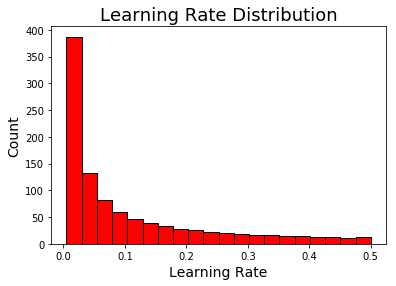

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Learning rate histogram
plt.hist(param_grid['learning_rate'], bins = 20, color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

### 5.Grid Search Implementation

In [179]:
import itertools

def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        print('iter:%d'%i)
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        print('result:',eval_results)
        i += 1
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results

In [180]:
grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

iter:0
result: [0.7990810879186726, {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 441}, 0]
iter:1
result: [0.7990810879186726, {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 441}, 1]
iter:2


KeyboardInterrupt: 

In [28]:
pd.options.display.max_colwidth = 1000
grid_results['params'].values

array([{'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 118},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 118},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5050505050505051, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 118},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 

### 6.Random Search

In [181]:
random.seed(50)

# Randomly sample from dictionary
random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
# Deal with subsample ratio
random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

random_params

{'boosting_type': 'goss',
 'num_leaves': 88,
 'learning_rate': 0.027778881111994384,
 'subsample_for_bin': 220000,
 'min_child_samples': 175,
 'reg_alpha': 0.8979591836734693,
 'reg_lambda': 0.6122448979591836,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 1.0,
 'is_unbalance': False}

In [182]:
def random_search(param_grid, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in range(MAX_EVALS):
        print('iter:%d'%i)
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(hyperparameters, i)
        print(eval_results)
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [183]:
random_results = random_search(param_grid)

print('The best validation score was {:.5f}'.format(random_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(random_results.loc[0, 'params'])

iter:0
[0.797440982248911, {'boosting_type': 'gbdt', 'num_leaves': 41, 'learning_rate': 0.40260198354127363, 'subsample_for_bin': 60000, 'min_child_samples': 240, 'reg_alpha': 0.12244897959183673, 'reg_lambda': 0.44897959183673464, 'colsample_bytree': 0.8222222222222222, 'subsample': 0.6414141414141414, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 5}, 0]
iter:1
[0.7980381129467973, {'boosting_type': 'gbdt', 'num_leaves': 104, 'learning_rate': 0.08633904519421778, 'subsample_for_bin': 200000, 'min_child_samples': 290, 'reg_alpha': 0.8163265306122448, 'reg_lambda': 0.1020408163265306, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.9444444444444444, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 16}, 1]
iter:2


KeyboardInterrupt: 

### 7.查看我们的自己模型的baseline

In [194]:
hyperparameters_own = {  #'random_search_runs': 0,
                      'device': 'cpu', # gpu cpu
                      'num_threads':-1,
                      'boosting_type': 'gbdt',
                      'objective': 'binary',
                      'metric': 'auc',
                      'learning_rate': 0.01291549665014884,
                      'max_bin': 300,
                      'max_depth': -1,
                      'num_leaves': 30,
                      'min_child_samples': 10,
                      'subsample': 1.0,
                      'subsample_freq': 1,
                      'colsample_bytree': 0.01,
                      'min_gain_to_split': 0.5,
                      'reg_lambda': 4,
                      'reg_alpha': 0.001,
                      'scale_pos_weight': 1,  
                      'is_unbalance': False}

In [195]:
score, params, iteration = objective(hyperparameters_own, 1)

print('The cross-validation ROC AUC was {:.5f}.'.format(score))

The cross-validation ROC AUC was 0.79898.


### 8.增大迭代次数并将结果写进文件

In [186]:
import csv

# Create file and open connection
out_file = 'random_search_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

In [187]:
def random_search(param_grid, out_file, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization. 
       Writes result of search to csv file every search iteration."""
    
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    for i in range(MAX_EVALS):
        print('iter:%d'%i)
        # Choose random hyperparameters
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(random_params, i)
        results.loc[i, :] = eval_results
        print(eval_results)
        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)

    return results 


In [188]:
def grid_search(param_grid, out_file, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)
       Writes result of search to csv file every search iteration."""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        print('iter:%d'%i)
        # Select the hyperparameters
        parameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        parameters['subsample'] = 1.0 if parameters['boosting_type'] == 'goss' else parameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(parameters, i)
        print(eval_results)
        results.loc[i, :] = eval_results
        
        i += 1
        
        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

In [189]:
MAX_EVALS = 1000
# Create file and open connection
out_file = 'random_search_trials_1000.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()
random_results = random_search(param_grid, out_file)

iter:0
[0.7979526962367132, {'boosting_type': 'goss', 'num_leaves': 137, 'learning_rate': 0.009062087736871187, 'subsample_for_bin': 100000, 'min_child_samples': 415, 'reg_alpha': 0.26530612244897955, 'reg_lambda': 0.6938775510204082, 'colsample_bytree': 1.0, 'subsample': 1.0, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 107}, 0]
iter:1
[0.7981163538412173, {'boosting_type': 'dart', 'num_leaves': 50, 'learning_rate': 0.2797162853084688, 'subsample_for_bin': 220000, 'min_child_samples': 365, 'reg_alpha': 0.6326530612244897, 'reg_lambda': 0.5510204081632653, 'colsample_bytree': 0.9555555555555555, 'subsample': 0.8434343434343434, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 8}, 1]
iter:2
[0.7987162686128981, {'boosting_type': 'goss', 'num_leaves': 96, 'learning_rate': 0.007747475196573157, 'subsample_for_bin': 280000, 'min_child_samples': 255, 'reg_alpha': 0.9795918367346939, 'reg_lambda': 0.673469387755102, 'colsample_bytree': 0.688888888

[0.7977366003203816, {'boosting_type': 'gbdt', 'num_leaves': 41, 'learning_rate': 0.33790905840805546, 'subsample_for_bin': 260000, 'min_child_samples': 250, 'reg_alpha': 0.5102040816326531, 'reg_lambda': 0.7959183673469387, 'colsample_bytree': 0.6, 'subsample': 0.5252525252525253, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 6}, 22]
iter:23
[0.7983830056144302, {'boosting_type': 'goss', 'num_leaves': 100, 'learning_rate': 0.03679907237632883, 'subsample_for_bin': 260000, 'min_child_samples': 95, 'reg_alpha': 0.673469387755102, 'reg_lambda': 0.6122448979591836, 'colsample_bytree': 0.9111111111111111, 'subsample': 1.0, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 23}, 23]
iter:24
[0.7984895793835156, {'boosting_type': 'dart', 'num_leaves': 50, 'learning_rate': 0.2092144253950791, 'subsample_for_bin': 240000, 'min_child_samples': 95, 'reg_alpha': 0.3061224489795918, 'reg_lambda': 0.8571428571428571, 'colsample_bytree': 0.6888888888888889,

[0.7988868987688543, {'boosting_type': 'dart', 'num_leaves': 44, 'learning_rate': 0.01868712871195532, 'subsample_for_bin': 40000, 'min_child_samples': 470, 'reg_alpha': 0.5102040816326531, 'reg_lambda': 0.673469387755102, 'colsample_bytree': 0.8666666666666667, 'subsample': 0.6565656565656566, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 307}, 44]
iter:45
[0.7972687757394354, {'boosting_type': 'gbdt', 'num_leaves': 100, 'learning_rate': 0.2053920444982823, 'subsample_for_bin': 40000, 'min_child_samples': 240, 'reg_alpha': 0.6326530612244897, 'reg_lambda': 0.2040816326530612, 'colsample_bytree': 0.6888888888888889, 'subsample': 0.994949494949495, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 7}, 45]
iter:46
[0.7990097273780795, {'boosting_type': 'dart', 'num_leaves': 28, 'learning_rate': 0.016198713147640983, 'subsample_for_bin': 20000, 'min_child_samples': 485, 'reg_alpha': 0.8979591836734693, 'reg_lambda': 0.1020408163265306, 'colsample

[0.7984443867079386, {'boosting_type': 'dart', 'num_leaves': 102, 'learning_rate': 0.06252692936451953, 'subsample_for_bin': 200000, 'min_child_samples': 100, 'reg_alpha': 0.2857142857142857, 'reg_lambda': 0.3469387755102041, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.595959595959596, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 21}, 66]
iter:67
[0.79852618434522, {'boosting_type': 'goss', 'num_leaves': 86, 'learning_rate': 0.05495548504647486, 'subsample_for_bin': 120000, 'min_child_samples': 165, 'reg_alpha': 0.061224489795918366, 'reg_lambda': 0.5510204081632653, 'colsample_bytree': 1.0, 'subsample': 1.0, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 17}, 67]
iter:68
[0.7988190250988423, {'boosting_type': 'dart', 'num_leaves': 34, 'learning_rate': 0.14943264367751918, 'subsample_for_bin': 60000, 'min_child_samples': 295, 'reg_alpha': 0.6938775510204082, 'reg_lambda': 0.5510204081632653, 'colsample_bytree': 0.7333333333333333

[0.7982446887090625, {'boosting_type': 'gbdt', 'num_leaves': 105, 'learning_rate': 0.07983130110507129, 'subsample_for_bin': 140000, 'min_child_samples': 250, 'reg_alpha': 0.6938775510204082, 'reg_lambda': 0.12244897959183673, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.5252525252525253, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 21}, 88]
iter:89
[0.7961742780661879, {'boosting_type': 'goss', 'num_leaves': 86, 'learning_rate': 0.3538505330590944, 'subsample_for_bin': 20000, 'min_child_samples': 95, 'reg_alpha': 0.3061224489795918, 'reg_lambda': 0.9387755102040816, 'colsample_bytree': 0.6444444444444444, 'subsample': 1.0, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 2}, 89]
iter:90
[0.7990585951162867, {'boosting_type': 'gbdt', 'num_leaves': 32, 'learning_rate': 0.00789165702826059, 'subsample_for_bin': 120000, 'min_child_samples': 315, 'reg_alpha': 0.6938775510204082, 'reg_lambda': 0.0, 'colsample_bytree': 0.6888888888888889

[0.7984761797677467, {'boosting_type': 'gbdt', 'num_leaves': 124, 'learning_rate': 0.012983279864674353, 'subsample_for_bin': 60000, 'min_child_samples': 225, 'reg_alpha': 0.4693877551020408, 'reg_lambda': 0.4897959183673469, 'colsample_bytree': 0.9111111111111111, 'subsample': 0.9797979797979799, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 113}, 110]
iter:111
[0.7990434863071523, {'boosting_type': 'gbdt', 'num_leaves': 26, 'learning_rate': 0.005187833393725929, 'subsample_for_bin': 120000, 'min_child_samples': 420, 'reg_alpha': 0.4897959183673469, 'reg_lambda': 0.8775510204081632, 'colsample_bytree': 0.9555555555555555, 'subsample': 0.8383838383838385, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 449}, 111]
iter:112
[0.7983031898752849, {'boosting_type': 'goss', 'num_leaves': 143, 'learning_rate': 0.013224900912138599, 'subsample_for_bin': 180000, 'min_child_samples': 155, 'reg_alpha': 0.9387755102040816, 'reg_lambda': 1.0, 'colsample_

[0.7974491732296605, {'boosting_type': 'goss', 'num_leaves': 80, 'learning_rate': 0.24246870336676174, 'subsample_for_bin': 120000, 'min_child_samples': 90, 'reg_alpha': 1.0, 'reg_lambda': 0.7959183673469387, 'colsample_bytree': 0.6444444444444444, 'subsample': 1.0, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 4}, 132]
iter:133
[0.7988828290663028, {'boosting_type': 'dart', 'num_leaves': 52, 'learning_rate': 0.0645774832507442, 'subsample_for_bin': 240000, 'min_child_samples': 25, 'reg_alpha': 0.4693877551020408, 'reg_lambda': 0.3877551020408163, 'colsample_bytree': 0.7777777777777778, 'subsample': 0.5757575757575758, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 40}, 133]
iter:134
[0.7986789571202939, {'boosting_type': 'dart', 'num_leaves': 57, 'learning_rate': 0.08476161707770602, 'subsample_for_bin': 280000, 'min_child_samples': 335, 'reg_alpha': 0.22448979591836732, 'reg_lambda': 0.26530612244897955, 'colsample_bytree': 0.955555555555

[0.7981998572883952, {'boosting_type': 'gbdt', 'num_leaves': 133, 'learning_rate': 0.017438637374070885, 'subsample_for_bin': 100000, 'min_child_samples': 380, 'reg_alpha': 0.673469387755102, 'reg_lambda': 0.8163265306122448, 'colsample_bytree': 0.9555555555555555, 'subsample': 0.7474747474747475, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 82}, 154]
iter:155
[0.7981583048246296, {'boosting_type': 'goss', 'num_leaves': 20, 'learning_rate': 0.2092144253950791, 'subsample_for_bin': 140000, 'min_child_samples': 75, 'reg_alpha': 0.16326530612244897, 'reg_lambda': 0.26530612244897955, 'colsample_bytree': 0.6, 'subsample': 1.0, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 4}, 155]
iter:156
[0.79757415897797, {'boosting_type': 'dart', 'num_leaves': 137, 'learning_rate': 0.09599603327966418, 'subsample_for_bin': 60000, 'min_child_samples': 220, 'reg_alpha': 0.3877551020408163, 'reg_lambda': 0.5102040816326531, 'colsample_bytree': 0.6, 'subsample

[0.7946099558872273, {'boosting_type': 'goss', 'num_leaves': 129, 'learning_rate': 0.33326816340624565, 'subsample_for_bin': 100000, 'min_child_samples': 495, 'reg_alpha': 0.16326530612244897, 'reg_lambda': 0.7755102040816326, 'colsample_bytree': 0.7333333333333333, 'subsample': 1.0, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 3}, 176]
iter:177
[0.7985587025928916, {'boosting_type': 'gbdt', 'num_leaves': 69, 'learning_rate': 0.08835217630444732, 'subsample_for_bin': 160000, 'min_child_samples': 395, 'reg_alpha': 0.2040816326530612, 'reg_lambda': 0.6122448979591836, 'colsample_bytree': 0.8666666666666667, 'subsample': 0.5606060606060606, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 18}, 177]
iter:178
[0.7986075406092447, {'boosting_type': 'gbdt', 'num_leaves': 99, 'learning_rate': 0.03131603726099344, 'subsample_for_bin': 20000, 'min_child_samples': 330, 'reg_alpha': 0.5714285714285714, 'reg_lambda': 0.4897959183673469, 'colsample_bytre

[0.7979917527586149, {'boosting_type': 'goss', 'num_leaves': 119, 'learning_rate': 0.025803743551929534, 'subsample_for_bin': 100000, 'min_child_samples': 475, 'reg_alpha': 0.12244897959183673, 'reg_lambda': 0.44897959183673464, 'colsample_bytree': 0.9111111111111111, 'subsample': 1.0, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 37}, 198]
iter:199
[0.7987867865083224, {'boosting_type': 'goss', 'num_leaves': 87, 'learning_rate': 0.0052358840974276, 'subsample_for_bin': 40000, 'min_child_samples': 30, 'reg_alpha': 0.14285714285714285, 'reg_lambda': 0.5102040816326531, 'colsample_bytree': 0.7333333333333333, 'subsample': 1.0, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 190}, 199]
iter:200
[0.7988956372987073, {'boosting_type': 'dart', 'num_leaves': 43, 'learning_rate': 0.009020409643596912, 'subsample_for_bin': 60000, 'min_child_samples': 285, 'reg_alpha': 0.6122448979591836, 'reg_lambda': 0.7755102040816326, 'colsample_bytree': 0.9555555

[0.7984711173992535, {'boosting_type': 'goss', 'num_leaves': 126, 'learning_rate': 0.01228458231491395, 'subsample_for_bin': 100000, 'min_child_samples': 155, 'reg_alpha': 0.42857142857142855, 'reg_lambda': 0.7959183673469387, 'colsample_bytree': 0.8666666666666667, 'subsample': 1.0, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 62}, 220]
iter:221
[0.7988546393859435, {'boosting_type': 'goss', 'num_leaves': 24, 'learning_rate': 0.016884901554125455, 'subsample_for_bin': 100000, 'min_child_samples': 150, 'reg_alpha': 1.0, 'reg_lambda': 0.16326530612244897, 'colsample_bytree': 0.8222222222222222, 'subsample': 1.0, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 58}, 221]
iter:222
[0.7988093258175722, {'boosting_type': 'goss', 'num_leaves': 27, 'learning_rate': 0.06517561223407543, 'subsample_for_bin': 260000, 'min_child_samples': 210, 'reg_alpha': 0.6122448979591836, 'reg_lambda': 0.3469387755102041, 'colsample_bytree': 0.6, 'subsample': 1.0, '

[0.7965395056593763, {'boosting_type': 'dart', 'num_leaves': 92, 'learning_rate': 0.34419760348227474, 'subsample_for_bin': 100000, 'min_child_samples': 195, 'reg_alpha': 0.6326530612244897, 'reg_lambda': 0.9591836734693877, 'colsample_bytree': 0.7333333333333333, 'subsample': 0.9292929292929293, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 4}, 243]
iter:244
[0.7988549295383787, {'boosting_type': 'gbdt', 'num_leaves': 121, 'learning_rate': 0.013347392470171603, 'subsample_for_bin': 260000, 'min_child_samples': 45, 'reg_alpha': 0.2857142857142857, 'reg_lambda': 0.6530612244897959, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.8181818181818182, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 160}, 244]
iter:245
[0.7982170547135856, {'boosting_type': 'gbdt', 'num_leaves': 72, 'learning_rate': 0.10334401248145408, 'subsample_for_bin': 60000, 'min_child_samples': 350, 'reg_alpha': 0.9387755102040816, 'reg_lambda': 0.6530612244897959, 'co

[0.7982697102945095, {'boosting_type': 'dart', 'num_leaves': 90, 'learning_rate': 0.08476161707770602, 'subsample_for_bin': 200000, 'min_child_samples': 205, 'reg_alpha': 0.5306122448979591, 'reg_lambda': 0.8775510204081632, 'colsample_bytree': 1.0, 'subsample': 0.7272727272727273, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 19}, 265]
iter:266
[0.7980473857551333, {'boosting_type': 'dart', 'num_leaves': 131, 'learning_rate': 0.09511505943344722, 'subsample_for_bin': 140000, 'min_child_samples': 35, 'reg_alpha': 0.9387755102040816, 'reg_lambda': 0.5306122448979591, 'colsample_bytree': 0.6, 'subsample': 0.696969696969697, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 16}, 266]
iter:267
[0.7986971663509344, {'boosting_type': 'goss', 'num_leaves': 42, 'learning_rate': 0.045701553743781154, 'subsample_for_bin': 40000, 'min_child_samples': 105, 'reg_alpha': 0.673469387755102, 'reg_lambda': 0.7346938775510203, 'colsample_bytree': 0.82222222222

[0.797354759782285, {'boosting_type': 'dart', 'num_leaves': 141, 'learning_rate': 0.21018108419223566, 'subsample_for_bin': 20000, 'min_child_samples': 35, 'reg_alpha': 0.24489795918367346, 'reg_lambda': 0.04081632653061224, 'colsample_bytree': 0.6888888888888889, 'subsample': 0.5151515151515151, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 12}, 287]
iter:288
[0.798187572501061, {'boosting_type': 'gbdt', 'num_leaves': 140, 'learning_rate': 0.019478728078877513, 'subsample_for_bin': 180000, 'min_child_samples': 480, 'reg_alpha': 0.12244897959183673, 'reg_lambda': 0.9183673469387754, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.5808080808080808, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 52}, 288]
iter:289
[0.7989716225673444, {'boosting_type': 'dart', 'num_leaves': 35, 'learning_rate': 0.010947383814283103, 'subsample_for_bin': 20000, 'min_child_samples': 285, 'reg_alpha': 0.061224489795918366, 'reg_lambda': 0.8571428571428571,

[0.7977067831080789, {'boosting_type': 'goss', 'num_leaves': 120, 'learning_rate': 0.11758214422471741, 'subsample_for_bin': 280000, 'min_child_samples': 255, 'reg_alpha': 0.14285714285714285, 'reg_lambda': 0.3061224489795918, 'colsample_bytree': 0.6888888888888889, 'subsample': 1.0, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 8}, 309]
iter:310
[0.7988243207596442, {'boosting_type': 'dart', 'num_leaves': 57, 'learning_rate': 0.005715155645572393, 'subsample_for_bin': 160000, 'min_child_samples': 405, 'reg_alpha': 0.12244897959183673, 'reg_lambda': 0.2040816326530612, 'colsample_bytree': 0.7777777777777778, 'subsample': 0.702020202020202, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 384}, 310]
iter:311
[0.7945517163932069, {'boosting_type': 'dart', 'num_leaves': 144, 'learning_rate': 0.3053203771116019, 'subsample_for_bin': 180000, 'min_child_samples': 275, 'reg_alpha': 0.02040816326530612, 'reg_lambda': 0.673469387755102, 'colsample_byt

[0.799006901706117, {'boosting_type': 'dart', 'num_leaves': 27, 'learning_rate': 0.0390717530392227, 'subsample_for_bin': 140000, 'min_child_samples': 110, 'reg_alpha': 0.5918367346938775, 'reg_lambda': 0.8775510204081632, 'colsample_bytree': 0.7777777777777778, 'subsample': 0.7727272727272727, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 208}, 331]
iter:332
[0.7984040455212805, {'boosting_type': 'goss', 'num_leaves': 80, 'learning_rate': 0.07180044923256299, 'subsample_for_bin': 40000, 'min_child_samples': 275, 'reg_alpha': 0.32653061224489793, 'reg_lambda': 0.8775510204081632, 'colsample_bytree': 0.6888888888888889, 'subsample': 1.0, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 13}, 332]
iter:333
[0.7986504597157702, {'boosting_type': 'goss', 'num_leaves': 75, 'learning_rate': 0.04304323848074622, 'subsample_for_bin': 280000, 'min_child_samples': 255, 'reg_alpha': 0.4693877551020408, 'reg_lambda': 0.7755102040816326, 'colsample_bytree':

[0.7987836249241662, {'boosting_type': 'gbdt', 'num_leaves': 96, 'learning_rate': 0.005163973659594757, 'subsample_for_bin': 160000, 'min_child_samples': 165, 'reg_alpha': 1.0, 'reg_lambda': 0.32653061224489793, 'colsample_bytree': 0.6, 'subsample': 0.6919191919191919, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 255}, 353]
iter:354
[0.7963407399427843, {'boosting_type': 'dart', 'num_leaves': 98, 'learning_rate': 0.35712796427715626, 'subsample_for_bin': 260000, 'min_child_samples': 80, 'reg_alpha': 1.0, 'reg_lambda': 0.5918367346938775, 'colsample_bytree': 0.8222222222222222, 'subsample': 0.8686868686868687, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 4}, 354]
iter:355
[0.7988683618242668, {'boosting_type': 'dart', 'num_leaves': 34, 'learning_rate': 0.06608320919733025, 'subsample_for_bin': 160000, 'min_child_samples': 460, 'reg_alpha': 0.673469387755102, 'reg_lambda': 0.5306122448979591, 'colsample_bytree': 1.0, 'subsample': 0.722222

[0.7986608754267361, {'boosting_type': 'dart', 'num_leaves': 66, 'learning_rate': 0.010263188763546259, 'subsample_for_bin': 20000, 'min_child_samples': 205, 'reg_alpha': 0.5714285714285714, 'reg_lambda': 0.673469387755102, 'colsample_bytree': 1.0, 'subsample': 0.9191919191919192, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 279}, 375]
iter:376
[0.7980708316505865, {'boosting_type': 'gbdt', 'num_leaves': 75, 'learning_rate': 0.1838804550800516, 'subsample_for_bin': 140000, 'min_child_samples': 95, 'reg_alpha': 0.3877551020408163, 'reg_lambda': 0.22448979591836732, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.6212121212121212, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 9}, 376]
iter:377
[0.7987093505300729, {'boosting_type': 'goss', 'num_leaves': 73, 'learning_rate': 0.022264792549713273, 'subsample_for_bin': 240000, 'min_child_samples': 340, 'reg_alpha': 0.3469387755102041, 'reg_lambda': 0.8163265306122448, 'colsample_bytree'

[0.7990683407627263, {'boosting_type': 'gbdt', 'num_leaves': 24, 'learning_rate': 0.013471018568409416, 'subsample_for_bin': 280000, 'min_child_samples': 95, 'reg_alpha': 0.5918367346938775, 'reg_lambda': 0.673469387755102, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.5252525252525253, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 160}, 397]
iter:398
[0.7986599386297137, {'boosting_type': 'gbdt', 'num_leaves': 87, 'learning_rate': 0.028426589569368763, 'subsample_for_bin': 100000, 'min_child_samples': 495, 'reg_alpha': 0.12244897959183673, 'reg_lambda': 0.18367346938775508, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.893939393939394, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 48}, 398]
iter:399
[0.7952421119397702, {'boosting_type': 'dart', 'num_leaves': 123, 'learning_rate': 0.39342857534684234, 'subsample_for_bin': 120000, 'min_child_samples': 225, 'reg_alpha': 0.24489795918367346, 'reg_lambda': 0.3061224489795918

[0.7985090011344081, {'boosting_type': 'dart', 'num_leaves': 144, 'learning_rate': 0.022162392956201978, 'subsample_for_bin': 160000, 'min_child_samples': 220, 'reg_alpha': 0.02040816326530612, 'reg_lambda': 0.44897959183673464, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.601010101010101, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 72}, 419]
iter:420
[0.7986434895849838, {'boosting_type': 'gbdt', 'num_leaves': 53, 'learning_rate': 0.09778253579329745, 'subsample_for_bin': 280000, 'min_child_samples': 80, 'reg_alpha': 0.36734693877551017, 'reg_lambda': 0.8775510204081632, 'colsample_bytree': 0.6, 'subsample': 0.9444444444444444, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 20}, 420]
iter:421
[0.7965908814383145, {'boosting_type': 'gbdt', 'num_leaves': 95, 'learning_rate': 0.27460582419438945, 'subsample_for_bin': 40000, 'min_child_samples': 480, 'reg_alpha': 0.6938775510204082, 'reg_lambda': 0.061224489795918366, 'colsample_byt

[0.7990869727679917, {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.012398364462510792, 'subsample_for_bin': 280000, 'min_child_samples': 205, 'reg_alpha': 0.6530612244897959, 'reg_lambda': 0.7959183673469387, 'colsample_bytree': 0.7333333333333333, 'subsample': 0.7525252525252526, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 190}, 441]
iter:442
[0.7985836911831499, {'boosting_type': 'goss', 'num_leaves': 96, 'learning_rate': 0.013103533482419261, 'subsample_for_bin': 240000, 'min_child_samples': 185, 'reg_alpha': 0.16326530612244897, 'reg_lambda': 0.6938775510204082, 'colsample_bytree': 0.9555555555555555, 'subsample': 1.0, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 77}, 442]
iter:443
[0.7972512470116875, {'boosting_type': 'dart', 'num_leaves': 138, 'learning_rate': 0.18558359097378824, 'subsample_for_bin': 160000, 'min_child_samples': 155, 'reg_alpha': 0.8163265306122448, 'reg_lambda': 0.44897959183673464, 'colsample

[0.7969257241779064, {'boosting_type': 'goss', 'num_leaves': 139, 'learning_rate': 0.14602777560913732, 'subsample_for_bin': 60000, 'min_child_samples': 260, 'reg_alpha': 0.8163265306122448, 'reg_lambda': 0.24489795918367346, 'colsample_bytree': 0.8666666666666667, 'subsample': 1.0, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 6}, 463]
iter:464
[0.7986179260434412, {'boosting_type': 'dart', 'num_leaves': 71, 'learning_rate': 0.005848413519851922, 'subsample_for_bin': 280000, 'min_child_samples': 260, 'reg_alpha': 0.7346938775510203, 'reg_lambda': 1.0, 'colsample_bytree': 1.0, 'subsample': 0.7626262626262627, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 595}, 464]
iter:465
[0.7985378403043418, {'boosting_type': 'goss', 'num_leaves': 122, 'learning_rate': 0.006840788139837358, 'subsample_for_bin': 20000, 'min_child_samples': 400, 'reg_alpha': 0.4081632653061224, 'reg_lambda': 0.14285714285714285, 'colsample_bytree': 0.6444444444444444, 'su

[0.7974889500288793, {'boosting_type': 'dart', 'num_leaves': 67, 'learning_rate': 0.2695887320193751, 'subsample_for_bin': 200000, 'min_child_samples': 395, 'reg_alpha': 0.4081632653061224, 'reg_lambda': 0.12244897959183673, 'colsample_bytree': 0.8666666666666667, 'subsample': 0.7525252525252526, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 9}, 485]
iter:486
[0.7985706360854915, {'boosting_type': 'dart', 'num_leaves': 71, 'learning_rate': 0.09041224674389757, 'subsample_for_bin': 120000, 'min_child_samples': 45, 'reg_alpha': 0.44897959183673464, 'reg_lambda': 0.9591836734693877, 'colsample_bytree': 0.9111111111111111, 'subsample': 0.9393939393939394, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 31}, 486]
iter:487
[0.7984240275731131, {'boosting_type': 'dart', 'num_leaves': 115, 'learning_rate': 0.0317521258429798, 'subsample_for_bin': 200000, 'min_child_samples': 410, 'reg_alpha': 0.3469387755102041, 'reg_lambda': 0.5510204081632653, 'c

[0.7977480073348688, {'boosting_type': 'dart', 'num_leaves': 25, 'learning_rate': 0.42944142797731244, 'subsample_for_bin': 240000, 'min_child_samples': 160, 'reg_alpha': 0.3061224489795918, 'reg_lambda': 0.8571428571428571, 'colsample_bytree': 0.7777777777777778, 'subsample': 0.8131313131313131, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 8}, 507]
iter:508
[0.7959026897162864, {'boosting_type': 'dart', 'num_leaves': 110, 'learning_rate': 0.3271793009441616, 'subsample_for_bin': 220000, 'min_child_samples': 425, 'reg_alpha': 0.08163265306122448, 'reg_lambda': 0.1020408163265306, 'colsample_bytree': 0.7333333333333333, 'subsample': 0.6363636363636364, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 4}, 508]
iter:509
[0.7975552485124455, {'boosting_type': 'goss', 'num_leaves': 127, 'learning_rate': 0.09914419745635356, 'subsample_for_bin': 140000, 'min_child_samples': 200, 'reg_alpha': 0.6530612244897959, 'reg_lambda': 0.36734693877551017, 

[0.7935039450605383, {'boosting_type': 'goss', 'num_leaves': 136, 'learning_rate': 0.44557411614201003, 'subsample_for_bin': 60000, 'min_child_samples': 465, 'reg_alpha': 0.08163265306122448, 'reg_lambda': 0.4693877551020408, 'colsample_bytree': 0.8666666666666667, 'subsample': 1.0, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 2}, 529]
iter:530
[0.7974217821779219, {'boosting_type': 'gbdt', 'num_leaves': 41, 'learning_rate': 0.44970110870460217, 'subsample_for_bin': 80000, 'min_child_samples': 260, 'reg_alpha': 0.7551020408163265, 'reg_lambda': 0.5510204081632653, 'colsample_bytree': 0.8666666666666667, 'subsample': 0.6717171717171717, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 3}, 530]
iter:531
[0.7985437134232859, {'boosting_type': 'gbdt', 'num_leaves': 129, 'learning_rate': 0.030461745762003552, 'subsample_for_bin': 80000, 'min_child_samples': 35, 'reg_alpha': 0.8163265306122448, 'reg_lambda': 0.42857142857142855, 'colsample_bytree'

[0.7985775909393006, {'boosting_type': 'gbdt', 'num_leaves': 134, 'learning_rate': 0.022574838860180507, 'subsample_for_bin': 120000, 'min_child_samples': 175, 'reg_alpha': 0.02040816326530612, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.9646464646464648, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 53}, 551]
iter:552
[0.7984117546651397, {'boosting_type': 'gbdt', 'num_leaves': 132, 'learning_rate': 0.008574409849352694, 'subsample_for_bin': 140000, 'min_child_samples': 435, 'reg_alpha': 0.6938775510204082, 'reg_lambda': 0.02040816326530612, 'colsample_bytree': 0.7333333333333333, 'subsample': 0.7575757575757576, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 165}, 552]
iter:553
[0.7988048583491183, {'boosting_type': 'gbdt', 'num_leaves': 45, 'learning_rate': 0.07946414328114888, 'subsample_for_bin': 20000, 'min_child_samples': 130, 'reg_alpha': 0.9183673469387754, 'reg_lambda': 0.6530612244897959, 'colsample_bytree': 0.955

[0.7988346760593099, {'boosting_type': 'gbdt', 'num_leaves': 60, 'learning_rate': 0.0317521258429798, 'subsample_for_bin': 220000, 'min_child_samples': 75, 'reg_alpha': 0.9183673469387754, 'reg_lambda': 0.7755102040816326, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.7676767676767677, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 65}, 573]
iter:574
[0.7984424705382311, {'boosting_type': 'goss', 'num_leaves': 92, 'learning_rate': 0.020777276673594372, 'subsample_for_bin': 60000, 'min_child_samples': 485, 'reg_alpha': 0.5306122448979591, 'reg_lambda': 0.4081632653061224, 'colsample_bytree': 0.8222222222222222, 'subsample': 1.0, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 45}, 574]
iter:575
[0.7988329494791147, {'boosting_type': 'goss', 'num_leaves': 48, 'learning_rate': 0.01561221411546428, 'subsample_for_bin': 160000, 'min_child_samples': 190, 'reg_alpha': 0.08163265306122448, 'reg_lambda': 0.6938775510204082, 'colsample_bytree

[0.7977666048505164, {'boosting_type': 'gbdt', 'num_leaves': 91, 'learning_rate': 0.1440222076698148, 'subsample_for_bin': 220000, 'min_child_samples': 475, 'reg_alpha': 0.6326530612244897, 'reg_lambda': 0.22448979591836732, 'colsample_bytree': 0.9111111111111111, 'subsample': 0.7272727272727273, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 9}, 595]
iter:596
[0.79756797955692, {'boosting_type': 'goss', 'num_leaves': 144, 'learning_rate': 0.10871947378000399, 'subsample_for_bin': 160000, 'min_child_samples': 170, 'reg_alpha': 0.04081632653061224, 'reg_lambda': 0.6122448979591836, 'colsample_bytree': 1.0, 'subsample': 1.0, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 7}, 596]
iter:597
[0.7981183953920119, {'boosting_type': 'dart', 'num_leaves': 119, 'learning_rate': 0.02267914412755093, 'subsample_for_bin': 140000, 'min_child_samples': 465, 'reg_alpha': 0.4897959183673469, 'reg_lambda': 0.7755102040816326, 'colsample_bytree': 0.9111111111

[0.7979408942733414, {'boosting_type': 'goss', 'num_leaves': 113, 'learning_rate': 0.057814006560368794, 'subsample_for_bin': 180000, 'min_child_samples': 410, 'reg_alpha': 0.5306122448979591, 'reg_lambda': 0.7755102040816326, 'colsample_bytree': 0.8222222222222222, 'subsample': 1.0, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 15}, 617]
iter:618
[0.7987512088205827, {'boosting_type': 'goss', 'num_leaves': 52, 'learning_rate': 0.010947383814283103, 'subsample_for_bin': 60000, 'min_child_samples': 245, 'reg_alpha': 0.6122448979591836, 'reg_lambda': 0.061224489795918366, 'colsample_bytree': 0.9111111111111111, 'subsample': 1.0, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 91}, 618]
iter:619
[0.7977802300103518, {'boosting_type': 'goss', 'num_leaves': 100, 'learning_rate': 0.06195310784739581, 'subsample_for_bin': 160000, 'min_child_samples': 495, 'reg_alpha': 0.9183673469387754, 'reg_lambda': 0.5714285714285714, 'colsample_bytree': 0.91111

[0.79592117558279, {'boosting_type': 'goss', 'num_leaves': 148, 'learning_rate': 0.16386474249616917, 'subsample_for_bin': 260000, 'min_child_samples': 425, 'reg_alpha': 0.1020408163265306, 'reg_lambda': 0.6530612244897959, 'colsample_bytree': 0.8222222222222222, 'subsample': 1.0, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 6}, 639]
iter:640
[0.7988934390912311, {'boosting_type': 'goss', 'num_leaves': 23, 'learning_rate': 0.009273384615423496, 'subsample_for_bin': 140000, 'min_child_samples': 375, 'reg_alpha': 0.2857142857142857, 'reg_lambda': 0.36734693877551017, 'colsample_bytree': 0.7777777777777778, 'subsample': 1.0, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 106}, 640]
iter:641
[0.7989589647802516, {'boosting_type': 'dart', 'num_leaves': 30, 'learning_rate': 0.02165741611688199, 'subsample_for_bin': 260000, 'min_child_samples': 370, 'reg_alpha': 0.12244897959183673, 'reg_lambda': 0.4897959183673469, 'colsample_bytree': 0.777777777

[0.798757377701512, {'boosting_type': 'dart', 'num_leaves': 72, 'learning_rate': 0.013286005526622525, 'subsample_for_bin': 20000, 'min_child_samples': 330, 'reg_alpha': 0.4897959183673469, 'reg_lambda': 0.14285714285714285, 'colsample_bytree': 0.9111111111111111, 'subsample': 0.9797979797979799, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 347}, 662]
iter:663
[0.7979795220033976, {'boosting_type': 'goss', 'num_leaves': 68, 'learning_rate': 0.12369820504434063, 'subsample_for_bin': 200000, 'min_child_samples': 490, 'reg_alpha': 0.9591836734693877, 'reg_lambda': 0.8163265306122448, 'colsample_bytree': 0.7333333333333333, 'subsample': 1.0, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 7}, 663]
iter:664
[0.7986690300290452, {'boosting_type': 'dart', 'num_leaves': 85, 'learning_rate': 0.008038522108369117, 'subsample_for_bin': 220000, 'min_child_samples': 285, 'reg_alpha': 0.3469387755102041, 'reg_lambda': 0.44897959183673464, 'colsample_bytr

[0.7990307586501734, {'boosting_type': 'gbdt', 'num_leaves': 22, 'learning_rate': 0.03530358857068886, 'subsample_for_bin': 220000, 'min_child_samples': 150, 'reg_alpha': 0.2040816326530612, 'reg_lambda': 0.9795918367346939, 'colsample_bytree': 0.7333333333333333, 'subsample': 0.6717171717171717, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 65}, 684]
iter:685
[0.7988611145228355, {'boosting_type': 'goss', 'num_leaves': 41, 'learning_rate': 0.013286005526622525, 'subsample_for_bin': 200000, 'min_child_samples': 150, 'reg_alpha': 0.8163265306122448, 'reg_lambda': 0.12244897959183673, 'colsample_bytree': 0.6444444444444444, 'subsample': 1.0, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 74}, 685]
iter:686
[0.7986498079288327, {'boosting_type': 'dart', 'num_leaves': 50, 'learning_rate': 0.10334401248145408, 'subsample_for_bin': 80000, 'min_child_samples': 245, 'reg_alpha': 0.7142857142857142, 'reg_lambda': 0.4897959183673469, 'colsample_bytree

[0.7989708914670619, {'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.03449918560715009, 'subsample_for_bin': 260000, 'min_child_samples': 385, 'reg_alpha': 0.22448979591836732, 'reg_lambda': 0.14285714285714285, 'colsample_bytree': 0.9111111111111111, 'subsample': 0.8282828282828283, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 113}, 706]
iter:707
[0.79849232067803, {'boosting_type': 'goss', 'num_leaves': 87, 'learning_rate': 0.026527402626847867, 'subsample_for_bin': 280000, 'min_child_samples': 390, 'reg_alpha': 0.8979591836734693, 'reg_lambda': 0.4693877551020408, 'colsample_bytree': 0.6444444444444444, 'subsample': 1.0, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 33}, 707]
iter:708
[0.7982034812595554, {'boosting_type': 'dart', 'num_leaves': 116, 'learning_rate': 0.010947383814283103, 'subsample_for_bin': 140000, 'min_child_samples': 480, 'reg_alpha': 0.6122448979591836, 'reg_lambda': 0.3061224489795918, 'colsample_b

[0.7980056924789849, {'boosting_type': 'gbdt', 'num_leaves': 107, 'learning_rate': 0.13378192222760224, 'subsample_for_bin': 180000, 'min_child_samples': 110, 'reg_alpha': 0.18367346938775508, 'reg_lambda': 0.9387755102040816, 'colsample_bytree': 0.8222222222222222, 'subsample': 0.7676767676767677, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 12}, 728]
iter:729
[0.79865447523711, {'boosting_type': 'gbdt', 'num_leaves': 114, 'learning_rate': 0.01391279701103562, 'subsample_for_bin': 60000, 'min_child_samples': 125, 'reg_alpha': 0.5714285714285714, 'reg_lambda': 0.26530612244897955, 'colsample_bytree': 0.7777777777777778, 'subsample': 0.6262626262626263, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 118}, 729]
iter:730
[0.798492006289444, {'boosting_type': 'dart', 'num_leaves': 83, 'learning_rate': 0.06281583012370603, 'subsample_for_bin': 120000, 'min_child_samples': 185, 'reg_alpha': 0.7755102040816326, 'reg_lambda': 0.32653061224489793,

[0.7969634476620014, {'boosting_type': 'dart', 'num_leaves': 118, 'learning_rate': 0.17804162763146386, 'subsample_for_bin': 160000, 'min_child_samples': 395, 'reg_alpha': 0.5102040816326531, 'reg_lambda': 0.9795918367346939, 'colsample_bytree': 0.6, 'subsample': 0.8686868686868687, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 13}, 750]
iter:751
[0.7987276041218115, {'boosting_type': 'gbdt', 'num_leaves': 99, 'learning_rate': 0.006532600810623605, 'subsample_for_bin': 20000, 'min_child_samples': 105, 'reg_alpha': 0.9795918367346939, 'reg_lambda': 0.7346938775510203, 'colsample_bytree': 0.8666666666666667, 'subsample': 0.5505050505050505, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 265}, 751]
iter:752
[0.7976157712646014, {'boosting_type': 'goss', 'num_leaves': 98, 'learning_rate': 0.1708061634292764, 'subsample_for_bin': 240000, 'min_child_samples': 160, 'reg_alpha': 0.7959183673469387, 'reg_lambda': 0.16326530612244897, 'colsample_bytr

[0.7986435714823458, {'boosting_type': 'dart', 'num_leaves': 56, 'learning_rate': 0.09778253579329745, 'subsample_for_bin': 220000, 'min_child_samples': 85, 'reg_alpha': 0.4693877551020408, 'reg_lambda': 0.4081632653061224, 'colsample_bytree': 1.0, 'subsample': 0.7828282828282829, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 26}, 772]
iter:773
[0.7960221528865332, {'boosting_type': 'gbdt', 'num_leaves': 119, 'learning_rate': 0.2634460710675337, 'subsample_for_bin': 140000, 'min_child_samples': 270, 'reg_alpha': 0.7959183673469387, 'reg_lambda': 0.16326530612244897, 'colsample_bytree': 0.8666666666666667, 'subsample': 0.5404040404040404, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 4}, 773]
iter:774
[0.7987020284392853, {'boosting_type': 'gbdt', 'num_leaves': 73, 'learning_rate': 0.014237195832336229, 'subsample_for_bin': 40000, 'min_child_samples': 395, 'reg_alpha': 0.44897959183673464, 'reg_lambda': 0.22448979591836732, 'colsample_bytre

[0.7987159487361055, {'boosting_type': 'dart', 'num_leaves': 67, 'learning_rate': 0.015756817424332395, 'subsample_for_bin': 240000, 'min_child_samples': 430, 'reg_alpha': 0.12244897959183673, 'reg_lambda': 0.36734693877551017, 'colsample_bytree': 0.8666666666666667, 'subsample': 0.8737373737373737, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 114}, 794]
iter:795
[0.7987643197286108, {'boosting_type': 'dart', 'num_leaves': 72, 'learning_rate': 0.019122848612334993, 'subsample_for_bin': 280000, 'min_child_samples': 375, 'reg_alpha': 0.24489795918367346, 'reg_lambda': 0.18367346938775508, 'colsample_bytree': 0.7777777777777778, 'subsample': 0.8585858585858586, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 58}, 795]
iter:796
[0.799022652114563, {'boosting_type': 'gbdt', 'num_leaves': 39, 'learning_rate': 0.005957253490598879, 'subsample_for_bin': 180000, 'min_child_samples': 30, 'reg_alpha': 0.3469387755102041, 'reg_lambda': 0.48979591836734

[0.7988073108781041, {'boosting_type': 'dart', 'num_leaves': 69, 'learning_rate': 0.04486657907291759, 'subsample_for_bin': 100000, 'min_child_samples': 185, 'reg_alpha': 0.12244897959183673, 'reg_lambda': 0.3469387755102041, 'colsample_bytree': 0.7333333333333333, 'subsample': 0.7323232323232324, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 59}, 816]
iter:817
[0.7987052389148401, {'boosting_type': 'gbdt', 'num_leaves': 121, 'learning_rate': 0.022367665272492326, 'subsample_for_bin': 180000, 'min_child_samples': 20, 'reg_alpha': 0.6122448979591836, 'reg_lambda': 0.26530612244897955, 'colsample_bytree': 0.6, 'subsample': 0.6111111111111112, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 103}, 817]
iter:818
[0.7971220280678833, {'boosting_type': 'dart', 'num_leaves': 70, 'learning_rate': 0.3410388366432842, 'subsample_for_bin': 20000, 'min_child_samples': 175, 'reg_alpha': 0.8571428571428571, 'reg_lambda': 0.5918367346938775, 'colsample_bytr

[0.7988066197317039, {'boosting_type': 'dart', 'num_leaves': 54, 'learning_rate': 0.0052358840974276, 'subsample_for_bin': 100000, 'min_child_samples': 435, 'reg_alpha': 0.32653061224489793, 'reg_lambda': 0.836734693877551, 'colsample_bytree': 0.8222222222222222, 'subsample': 0.601010101010101, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 423}, 838]
iter:839
[0.7985809586104544, {'boosting_type': 'dart', 'num_leaves': 97, 'learning_rate': 0.025922967719464562, 'subsample_for_bin': 100000, 'min_child_samples': 295, 'reg_alpha': 0.9795918367346939, 'reg_lambda': 0.18367346938775508, 'colsample_bytree': 0.8222222222222222, 'subsample': 0.7525252525252526, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 148}, 839]
iter:840
[0.7939462921731513, {'boosting_type': 'dart', 'num_leaves': 137, 'learning_rate': 0.4886073484862862, 'subsample_for_bin': 260000, 'min_child_samples': 185, 'reg_alpha': 0.44897959183673464, 'reg_lambda': 0.5306122448979591,

[0.7978167325683041, {'boosting_type': 'dart', 'num_leaves': 147, 'learning_rate': 0.07553516522433273, 'subsample_for_bin': 160000, 'min_child_samples': 125, 'reg_alpha': 0.2040816326530612, 'reg_lambda': 0.4897959183673469, 'colsample_bytree': 0.9111111111111111, 'subsample': 0.8787878787878789, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 15}, 860]
iter:861
[0.7989720713832535, {'boosting_type': 'dart', 'num_leaves': 26, 'learning_rate': 0.07873488573215429, 'subsample_for_bin': 260000, 'min_child_samples': 200, 'reg_alpha': 0.24489795918367346, 'reg_lambda': 0.32653061224489793, 'colsample_bytree': 0.7777777777777778, 'subsample': 0.8080808080808082, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 44}, 861]
iter:862
[0.7984598405397113, {'boosting_type': 'dart', 'num_leaves': 74, 'learning_rate': 0.09294783398178436, 'subsample_for_bin': 240000, 'min_child_samples': 155, 'reg_alpha': 0.14285714285714285, 'reg_lambda': 0.7551020408163265,

[0.7974629848647801, {'boosting_type': 'goss', 'num_leaves': 123, 'learning_rate': 0.10098928784099391, 'subsample_for_bin': 20000, 'min_child_samples': 295, 'reg_alpha': 0.7346938775510203, 'reg_lambda': 0.9591836734693877, 'colsample_bytree': 0.6888888888888889, 'subsample': 1.0, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 9}, 882]
iter:883
[0.798954202888073, {'boosting_type': 'dart', 'num_leaves': 27, 'learning_rate': 0.08057071386265094, 'subsample_for_bin': 20000, 'min_child_samples': 165, 'reg_alpha': 0.18367346938775508, 'reg_lambda': 0.7142857142857142, 'colsample_bytree': 0.6, 'subsample': 0.6363636363636364, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 64}, 883]
iter:884
[0.797678793045098, {'boosting_type': 'goss', 'num_leaves': 30, 'learning_rate': 0.31100244128173554, 'subsample_for_bin': 80000, 'min_child_samples': 20, 'reg_alpha': 1.0, 'reg_lambda': 0.6530612244897959, 'colsample_bytree': 0.6, 'subsample': 1.0, 'is_unba

KeyboardInterrupt: 

In [193]:
random_results = pd.read_csv(out_file)
random_results.sort_values('score',inplace=True,ascending=False)
random_results.reset_index(inplace=True,drop=True)
random_results.head()

,score,hyperparameters,iteration
0,0.799087,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.012398364462510792, 'subsample_for_bin': 280000, 'min_child_samples': 205, 'reg_alpha': 0.6530612244897959, 'reg_lambda': 0.7959183673469387, 'colsample_bytree': 0.7333333333333333, 'subsample': 0.7525252525252526, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 190}",441
1,0.799069,"{'boosting_type': 'dart', 'num_leaves': 21, 'learning_rate': 0.028955613238208788, 'subsample_for_bin': 60000, 'min_child_samples': 495, 'reg_alpha': 0.7959183673469387, 'reg_lambda': 0.36734693877551017, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.8383838383838385, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 276}",401
2,0.799068,"{'boosting_type': 'gbdt', 'num_leaves': 24, 'learning_rate': 0.013471018568409416, 'subsample_for_bin': 280000, 'min_child_samples': 95, 'reg_alpha': 0.5918367346938775, 'reg_lambda': 0.673469387755102, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.5252525252525253, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 160}",397
3,0.799068,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.01391279701103562, 'subsample_for_bin': 180000, 'min_child_samples': 190, 'reg_alpha': 0.2857142857142857, 'reg_lambda': 0.42857142857142855, 'colsample_bytree': 0.7333333333333333, 'subsample': 0.6060606060606061, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 310}",632
4,0.799066,"{'boosting_type': 'dart', 'num_leaves': 20, 'learning_rate': 0.05808113163042509, 'subsample_for_bin': 220000, 'min_child_samples': 35, 'reg_alpha': 0.8979591836734693, 'reg_lambda': 0.673469387755102, 'colsample_bytree': 0.7333333333333333, 'subsample': 0.98989898989899, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 137}",820


In [190]:
random_results.head()

,index,score,params,iteration
0,3,0.795611,"{'boosting_type': 'goss', 'num_leaves': 137, 'learning_rate': 0.009062087736871187, 'subsample_for_bin': 100000, 'min_child_samples': 415, 'reg_alpha': 0.26530612244897955, 'reg_lambda': 0.6938775510204082, 'colsample_bytree': 1.0, 'subsample': 1.0, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 77}",3
1,2,0.794101,"{'boosting_type': 'dart', 'num_leaves': 130, 'learning_rate': 0.005116582891651224, 'subsample_for_bin': 80000, 'min_child_samples': 235, 'reg_alpha': 0.3469387755102041, 'reg_lambda': 0.5510204081632653, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.6262626262626263, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 109}",2
2,1,0.793726,"{'boosting_type': 'gbdt', 'num_leaves': 104, 'learning_rate': 0.08633904519421778, 'subsample_for_bin': 200000, 'min_child_samples': 290, 'reg_alpha': 0.8163265306122448, 'reg_lambda': 0.1020408163265306, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.9444444444444444, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 9}",1
3,4,0.788755,"{'boosting_type': 'dart', 'num_leaves': 50, 'learning_rate': 0.2797162853084688, 'subsample_for_bin': 220000, 'min_child_samples': 365, 'reg_alpha': 0.6326530612244897, 'reg_lambda': 0.5510204081632653, 'colsample_bytree': 0.9555555555555555, 'subsample': 0.8434343434343434, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 3}",4
4,0,0.777164,"{'boosting_type': 'gbdt', 'num_leaves': 41, 'learning_rate': 0.40260198354127363, 'subsample_for_bin': 60000, 'min_child_samples': 240, 'reg_alpha': 0.12244897959183673, 'reg_lambda': 0.44897959183673464, 'colsample_bytree': 0.8222222222222222, 'subsample': 0.6414141414141414, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 2}",0


In [ ]:
# Create file and open connection
out_file = 'grid_search_trials_1000.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()
grid_results = grid_search(param_grid, out_file)

### 9.贝叶斯优化

In [46]:
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [ ]:
bayes_cv_tuner = BayesSearchCV(
    estimator = lgb.LGBMClassifier(
        application='binary',
        reg_alpha=0.04,
        reg_lambda=0.073,
        min_split_gain=0.0222415,
        min_child_weight=40,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        metric='auc',
        n_jobs=-1,
        verbose=0
    ),
    search_spaces = {
        'learning_rate': (0.01,0.2,'uniform'),
        'num_leaves': (30, 50),      
},    
    scoring = 'roc_auc',
    n_jobs = -1, 
    verbose = 0,
    refit = True,
    random_state = 921
)

# Fit the model
result = bayes_cv_tuner.fit(train_features,train_labels, callback=status_print)

### 10. 用Grid search微调我们自己模型参数

In [89]:
def grid_search(param_grid, out_file, BaseParams={}, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)
       Writes result of search to csv file every search iteration."""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        print('iter:%d'%i)
        # Select the hyperparameters
        parameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        #parameters['subsample'] = 1.0 if parameters['boosting_type'] == 'goss' else parameters['subsample']
        BaseParams.update(parameters)
        # Evalute the hyperparameters
        eval_results = objective(BaseParams, i)
        print(eval_results)
        results.loc[i, :] = eval_results
        
        i += 1
        
        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

In [90]:
def random_search(param_grid, out_file, BaseParams={}, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization. 
       Writes result of search to csv file every search iteration."""
    
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    for i in range(MAX_EVALS):
        print('iter:%d'%i)
        # Choose random hyperparameters
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        #random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']
        BaseParams.update(random_params)
        # Evaluate randomly selected hyperparameters
        eval_results = objective(BaseParams, i)
        results.loc[i, :] = eval_results
        print(eval_results)
        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)

    return results 


In [142]:
BaseParams = {  #'random_search_runs': 0,
                      'device': 'cpu', # gpu cpu
                      'num_threads':-1,
                      'boosting_type': 'gbdt',
                      'objective': 'binary',
                      'metric': 'auc',
                      'learning_rate': 0.01291549665014884,
                      'max_bin': 300,
                      'max_depth': -1,
                      'num_leaves': 30,
                      'min_child_samples': 10,
                      'subsample': 1.0,
                      'colsample_bytree': 0.01,
                      'min_gain_to_split': 0.30303030303030304,
                      'reg_lambda': 4,
                      'reg_alpha': 0.001,
                      'scale_pos_weight': 1,  
                      'is_unbalance': False}

In [144]:
param_grid_tmp = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

In [145]:
# Hyperparameter grid
param_grid = {
    'colsample_bytree': list(np.linspace(0, 1,1000)),
}
param_grid

{'colsample_bytree': [0.0,
  0.001001001001001001,
  0.002002002002002002,
  0.003003003003003003,
  0.004004004004004004,
  0.005005005005005005,
  0.006006006006006006,
  0.007007007007007007,
  0.008008008008008008,
  0.009009009009009009,
  0.01001001001001001,
  0.011011011011011011,
  0.012012012012012012,
  0.013013013013013013,
  0.014014014014014014,
  0.015015015015015015,
  0.016016016016016016,
  0.017017017017017015,
  0.018018018018018018,
  0.01901901901901902,
  0.02002002002002002,
  0.02102102102102102,
  0.022022022022022022,
  0.023023023023023025,
  0.024024024024024024,
  0.025025025025025023,
  0.026026026026026026,
  0.02702702702702703,
  0.028028028028028028,
  0.029029029029029027,
  0.03003003003003003,
  0.031031031031031032,
  0.03203203203203203,
  0.03303303303303303,
  0.03403403403403403,
  0.035035035035035036,
  0.036036036036036036,
  0.037037037037037035,
  0.03803803803803804,
  0.03903903903903904,
  0.04004004004004004,
  0.04104104104104104,
  

In [146]:
# Create file and open connection
out_file = 'grid_search_trials_test.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()
grid_results = random_search(param_grid.copy(), out_file, BaseParams.copy(),100)

iter:0
[0.797727626615637, {'device': 'cpu', 'num_threads': -1, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.01291549665014884, 'max_bin': 300, 'max_depth': -1, 'num_leaves': 30, 'min_child_samples': 10, 'subsample': 1.0, 'subsample_freq': 1, 'colsample_bytree': 0.24924924924924924, 'min_gain_to_split': 0.30303030303030304, 'reg_lambda': 4, 'reg_alpha': 0.001, 'scale_pos_weight': 1, 'is_unbalance': False, 'verbose': 1, 'n_estimators': 45}, 0]
iter:1
[0.7963019937262502, {'device': 'cpu', 'num_threads': -1, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.01291549665014884, 'max_bin': 300, 'max_depth': -1, 'num_leaves': 30, 'min_child_samples': 10, 'subsample': 1.0, 'subsample_freq': 1, 'colsample_bytree': 0.7177177177177178, 'min_gain_to_split': 0.30303030303030304, 'reg_lambda': 4, 'reg_alpha': 0.001, 'scale_pos_weight': 1, 'is_unbalance': False, 'verbose': 1, 'n_estimators': 35}, 1]
iter:2
[0.7967990546282083, 

KeyboardInterrupt: 

In [141]:
grid_results.head()

,index,score,params,iteration
0,71,0.799922,"{'device': 'cpu', 'num_threads': -1, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.01291549665014884, 'max_bin': 300, 'max_depth': -1, 'num_leaves': 30, 'min_child_samples': 10, 'subsample': 1.0, 'subsample_freq': 1, 'colsample_bytree': 0.01, 'min_gain_to_split': 22.727272727272727, 'reg_lambda': 4, 'reg_alpha': 0.001, 'scale_pos_weight': 1, 'is_unbalance': False, 'verbose': 1, 'n_estimators': 181}",71
1,29,0.799904,"{'device': 'cpu', 'num_threads': -1, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.01291549665014884, 'max_bin': 300, 'max_depth': -1, 'num_leaves': 30, 'min_child_samples': 10, 'subsample': 1.0, 'subsample_freq': 1, 'colsample_bytree': 0.01, 'min_gain_to_split': 22.727272727272727, 'reg_lambda': 4, 'reg_alpha': 0.001, 'scale_pos_weight': 1, 'is_unbalance': False, 'verbose': 1, 'n_estimators': 181}",29
2,20,0.79973,"{'device': 'cpu', 'num_threads': -1, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.01291549665014884, 'max_bin': 300, 'max_depth': -1, 'num_leaves': 30, 'min_child_samples': 10, 'subsample': 1.0, 'subsample_freq': 1, 'colsample_bytree': 0.01, 'min_gain_to_split': 22.727272727272727, 'reg_lambda': 4, 'reg_alpha': 0.001, 'scale_pos_weight': 1, 'is_unbalance': False, 'verbose': 1, 'n_estimators': 181}",20
3,37,0.799697,"{'device': 'cpu', 'num_threads': -1, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.01291549665014884, 'max_bin': 300, 'max_depth': -1, 'num_leaves': 30, 'min_child_samples': 10, 'subsample': 1.0, 'subsample_freq': 1, 'colsample_bytree': 0.01, 'min_gain_to_split': 22.727272727272727, 'reg_lambda': 4, 'reg_alpha': 0.001, 'scale_pos_weight': 1, 'is_unbalance': False, 'verbose': 1, 'n_estimators': 181}",37
4,27,0.799697,"{'device': 'cpu', 'num_threads': -1, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.01291549665014884, 'max_bin': 300, 'max_depth': -1, 'num_leaves': 30, 'min_child_samples': 10, 'subsample': 1.0, 'subsample_freq': 1, 'colsample_bytree': 0.01, 'min_gain_to_split': 22.727272727272727, 'reg_lambda': 4, 'reg_alpha': 0.001, 'scale_pos_weight': 1, 'is_unbalance': False, 'verbose': 1, 'n_estimators': 181}",27
